In [ ]:

# import pandas as pd

# # 파일 경로
# car_path = "../data/raw/서울특별시_행정동별 자동차 등록대수 현황_20220430.csv"
# coord_path = "../data/processed/admin_centroids.csv"
# grid_path = "../data/processed/grid_system_processed.csv"

# # 로딩
# df = pd.read_csv(car_path, encoding="cp949")
# coords = pd.read_csv(coord_path)
# grid = pd.read_csv(grid_path)

In [5]:
!pip install python-dotenv

In [62]:
import pandas as pd

# 파일 경로
file_path = "../data/raw/서울특별시_행정동별 자동차 등록대수 현황_20220430.csv"

# 데이터 불러오기
df = pd.read_csv(file_path, encoding="cp949")

In [63]:

df['계'] = pd.to_numeric(df['계'], errors='coerce')

# 현재 전기차 수요
ev_current = df[df['연료'] == '전기'].groupby(['사용본거지 시군구', '읍면동 (행정동)'])['계'].sum().reset_index()
ev_current.rename(columns={'계': 'current_ev_count'}, inplace=True)

# 전체 차량 → 미래 전기차 수요 계산
total = df.groupby(['사용본거지 시군구', '읍면동 (행정동)'])['계'].sum().reset_index()
total.rename(columns={'계': 'total_vehicles'}, inplace=True)
total['future_ev_count'] = total['total_vehicles'] * 0.1 # 전체 10%

# 합치기 (미래 수요 = 현재 전기차 + 미래 예측분)
future_demand = pd.merge(ev_current, total, on=['사용본거지 시군구', '읍면동 (행정동)'], how='outer').fillna(0)
future_demand['adjusted_ev_demand'] = future_demand['current_ev_count'] + future_demand['future_ev_count']


In [64]:
import requests
import time
import os
import pandas as pd
from dotenv import load_dotenv

# 0. API 키 로드
load_dotenv()
VWORLD_API_KEY = os.getenv('VWORLD')

# 1. '기타' 동 제거
future_demand = future_demand[~future_demand['읍면동 (행정동)'].str.contains("기타", na=False)].copy()

# 2. 기존 좌표 컬럼 제거
future_demand.drop(columns=[col for col in future_demand.columns if col.startswith('lat') or col.startswith('lon')], inplace=True, errors='ignore')

# 3. 고유한 읍면동(행정동)만 추출
area_list = future_demand[['읍면동 (행정동)']].drop_duplicates().copy()

# 4. 주소 생성: "개포1동" 형식만 사용
area_list['full_address'] = area_list['읍면동 (행정동)'].apply(lambda d: d.strip())

# 5. VWorld API 요청 함수
def get_coords_vworld(address):
    apiurl = "https://api.vworld.kr/req/address?"
    params = {
        "service": "address",
        "request": "getcoord",
        "crs": "epsg:4326",
        "address": address,
        "format": "json",
        "type": "road",  # 도로명 주소 기준
        "key": VWORLD_API_KEY
    }
    response = requests.get(apiurl, params=params)
    if response.status_code == 200:
        try:
            res = response.json()
            point = res['response']['result']['point']
            return float(point['y']), float(point['x'])
        except Exception as e:
            print(f"❗ {address} → 응답 파싱 실패: {e}")
            return None, None
    else:
        print(f"❗ {address} → 요청 실패: {response.status_code}")
        return None, None

# 6. 좌표 요청
lat_list, lon_list = [], []
for addr in area_list['full_address']:
    lat, lon = get_coords_vworld(addr)
    lat_list.append(lat)
    lon_list.append(lon)
    print(f"{addr} → lat: {lat}, lon: {lon}")
    time.sleep(0.3)

# 7. 좌표 정리 및 병합
area_list['lat'] = lat_list
area_list['lon'] = lon_list
coords = area_list[['읍면동 (행정동)', 'lat', 'lon']]
future_demand = pd.merge(future_demand, coords, on=['읍면동 (행정동)'], how='left')

# 8. 결과 확인
print(future_demand.head())

강남구 개포1동 → lat: 37.486260462, lon: 127.046056558
강남구 개포2동 → lat: 37.476184671, lon: 127.057632245
강남구 개포4동 → lat: 37.488426151, lon: 127.068779528
❗ 강남구 논현1동 → 응답 파싱 실패: 'result'
강남구 논현1동 → lat: None, lon: None
강남구 논현2동 → lat: 37.505859315, lon: 127.025582227
강남구 논현동 → lat: 37.505859315, lon: 127.025582227
강남구 대치1동 → lat: 37.498856638, lon: 127.071405333
강남구 대치2동 → lat: 37.498265504, lon: 127.07168982
강남구 대치4동 → lat: 37.501990841, lon: 127.050671792
강남구 도곡1동 → lat: 37.487976791, lon: 127.03717003
강남구 도곡2동 → lat: 37.488800651, lon: 127.036297866
강남구 삼성1동 → lat: 37.519422884, lon: 127.047844358
강남구 삼성2동 → lat: 37.512731458, lon: 127.051252663
강남구 세곡동 → lat: 37.466399182, lon: 127.099727739
강남구 수서동 → lat: 37.484723044, lon: 127.09484455
강남구 신사동 → lat: 37.522238454, lon: 127.029571607
강남구 압구정동 → lat: 37.522238454, lon: 127.029571607
강남구 역삼1동 → lat: 37.503415869, lon: 127.037115087
강남구 역삼2동 → lat: 37.490804994, lon: 127.034244012
❗ 강남구 일원1동 → 응답 파싱 실패: 'result'
강남구 일원1동 → lat: None, lon: No

In [65]:
print(future_demand.columns.tolist())

['사용본거지 시군구', '읍면동 (행정동)', 'current_ev_count', 'total_vehicles', 'future_ev_count', 'adjusted_ev_demand', 'lat', 'lon']


In [66]:
missing_count = future_demand[['lat', 'lon']].isna().any(axis=1).sum()
print(f"❗ 좌표가 없는 행의 수: {missing_count}")

❗ 좌표가 없는 행의 수: 130


### 행정동, 법정동 별 중심좌표 데이터셋 출처
https://torrms.tistory.com/55

In [67]:
import pandas as pd
import numpy as np

# 1. 엑셀 파일 로드
excel_file_path = "../data/raw/행정_법정동 중심좌표.xlsx"
df_excel = pd.read_excel(excel_file_path, sheet_name="합본 DB")

# 2. 서울특별시 데이터만 필터링
df_seoul = df_excel[df_excel['시도'] == '서울특별시'].copy()

# 3. 필요한 컬럼만 선택 및 컬럼명 정리
df_seoul = df_seoul[['시군구', '읍면동', '위도', '경도']].rename(columns={
    '위도': 'lat_excel',
    '경도': 'lon_excel'
})

# 4. future_demand에서 시군구와 읍면동 분리
# '00구 00동' 형식을 분리하여 새로운 컬럼 생성
future_demand['temp_sigungu'] = future_demand['읍면동 (행정동)'].apply(lambda x: x.split()[0] if pd.notna(x) and ' ' in x else x)
future_demand['temp_dong'] = future_demand['읍면동 (행정동)'].apply(lambda x: ' '.join(x.split()[1:]) if pd.notna(x) and ' ' in x else x)

# 5. 좌표가 없는 행 처리
# lat 또는 lon이 NaN인 행을 대상으로 엑셀 데이터에서 좌표 가져오기
for idx, row in future_demand[future_demand['lat'].isna() | future_demand['lon'].isna()].iterrows():
    sigungu = row['temp_sigungu']
    dong = row['temp_dong']
    
    # 엑셀 데이터에서 매칭되는 행 찾기
    match = df_seoul[(df_seoul['시군구'] == sigungu) & (df_seoul['읍면동'] == dong)]
    
    if not match.empty:
        # 첫 번째 매칭된 좌표로 업데이트
        future_demand.at[idx, 'lat'] = match.iloc[0]['lat_excel']
        future_demand.at[idx, 'lon'] = match.iloc[0]['lon_excel']
        print(f"Updated {sigungu}, {dong} with lat: {match.iloc[0]['lat_excel']}, lon: {match.iloc[0]['lon_excel']}")
    else:
        print(f"No match found for {sigungu}, {dong} in Excel data")

# 6. 임시 컬럼 삭제
future_demand.drop(columns=['temp_sigungu', 'temp_dong'], inplace=True)

# 7. 결과 확인
print("\nUpdated future_demand head:")
print(future_demand.head())
print("\nRows with missing coordinates after update:")
print(future_demand[future_demand['lat'].isna() | future_demand['lon'].isna()])

Updated 강남구, 논현1동 with lat: 37.511498, lon: 127.028552
Updated 강남구, 일원1동 with lat: 37.491887, lon: 127.087982
No match found for 강동구, 고덕1동 in Excel data
No match found for 강동구, 고덕2동 in Excel data
No match found for 강동구, 둔촌1동 in Excel data
No match found for 강동구, 둔촌2동 in Excel data
No match found for 강동구, 명일1동 in Excel data
No match found for 강동구, 명일2동 in Excel data
No match found for 강동구, 상일제1동 in Excel data
No match found for 강동구, 상일제2동 in Excel data
No match found for 강동구, 성내1동 in Excel data
No match found for 강동구, 성내2동 in Excel data
No match found for 강동구, 암사1동 in Excel data
No match found for 강동구, 암사2동 in Excel data
No match found for 강동구, 천호1동 in Excel data
No match found for 강동구, 천호3동 in Excel data
No match found for 강동구, 하일동 in Excel data
Updated 강북구, 삼각산동 with lat: 37.616702, lon: 127.017511
No match found for 강서구, 가양1동 in Excel data
No match found for 강서구, 가양3동 in Excel data
No match found for 강서구, 등촌2동 in Excel data
No match found for 강서구, 등촌3동 in Excel data
No match found fo

In [72]:
from geopy.geocoders import Nominatim
import time

geolocator = Nominatim(user_agent="ev-charger-locator")

def fetch_latlon(addr):
    try:
        location = geolocator.geocode(f"서울특별시 {addr}")
        if location:
            return pd.Series([location.latitude, location.longitude])
    except:
        return pd.Series([None, None])
    return pd.Series([None, None])

# 좌표 없는 행만 처리
mask = future_demand['lat'].isna() | future_demand['lon'].isna()
for idx, row in future_demand[mask].iterrows():
    addr = row['읍면동 (행정동)']
    lat, lon = fetch_latlon(addr)
    if lat and lon:
        future_demand.at[idx, 'lat'] = lat
        future_demand.at[idx, 'lon'] = lon
        print(f"[Nominatim] Updated {addr} → ({lat}, {lon})")
    else:
        print(f"[Nominatim] Failed to get coordinates for {addr}")
    time.sleep(1)  # 과금/차단 방지용 딜레이


[Nominatim] Updated 강동구 고덕1동  → (37.5628004, 127.1516983)
[Nominatim] Updated 강동구 고덕2동  → (37.5658618, 127.1638517)
[Nominatim] Updated 강동구 둔촌1동  → (37.5228488, 127.1402483)
[Nominatim] Updated 강동구 둔촌2동  → (37.5315232, 127.1456591)
[Nominatim] Updated 강동구 명일1동  → (37.5502157, 127.1466596)
[Nominatim] Updated 강동구 명일2동  → (37.5477443, 127.152496)
[Nominatim] Failed to get coordinates for 강동구 상일제1동 
[Nominatim] Failed to get coordinates for 강동구 상일제2동 
[Nominatim] Updated 강동구 성내1동  → (37.5285968, 127.1252778)
[Nominatim] Updated 강동구 성내2동  → (37.5347582, 127.1280422)
[Nominatim] Updated 강동구 암사1동  → (37.5509645, 127.1341494)
[Nominatim] Updated 강동구 암사2동  → (37.5581659, 127.1232649)
[Nominatim] Updated 강동구 천호1동  → (37.5465741, 127.1387019)
[Nominatim] Updated 강동구 천호3동  → (37.5392961, 127.131897)
[Nominatim] Updated 강동구 하일동  → (37.56723, 127.1713)
[Nominatim] Updated 강서구 가양1동  → (37.5722462, 126.8362193)
[Nominatim] Updated 강서구 가양3동  → (37.5619103, 126.8598672)
[Nominatim] Updated 강서구 등촌2동  → 

In [79]:
# 1. 실패한 주소 수집 (앞에서 출력된 실패 로그 기반 수작업 목록)
manual_mapping = {
    "강동구 상일제1동": "강동구 상일1동",
    "강동구 상일제2동": "강동구 상일2동",
    "구로구 구로본동": "구로구 구로2동",
    "노원구 공릉1.3동": "노원구 공릉1동",
    "노원구 월계4동": "노원구 월계2동",
    "서초구 도곡동": "강남구 도곡동",
    "종로구 명륜3가동": "종로구 명륜3가",
    "중구 남대문로5가동": "중구 남대문로5가",
    "중구 신당4동": "중구 청구동",
    "중구 을지로3.4.5가동": "중구 을지로동",
    "중구 태평로1가동": "중구 태평로1가"
}
drop_list = ["영등포구 평택시 서정동"]

# 2. 문자열 정제 (strip)
future_demand['읍면동 (행정동)'] = future_demand['읍면동 (행정동)'].astype(str).str.strip()

# 3. 수동 매핑 및 삭제 적용
for idx in future_demand.index:
    addr = future_demand.at[idx, '읍면동 (행정동)']
    if addr in manual_mapping:
        new_addr = manual_mapping[addr]
        future_demand.at[idx, '읍면동 (행정동)'] = new_addr
        print(f"[수정] {addr} → {new_addr}")

# 삭제는 따로 한 번에 처리
before = len(future_demand)
future_demand = future_demand[~future_demand['읍면동 (행정동)'].isin(drop_list)].copy()
after = len(future_demand)
print(f"[삭제 완료] {before - after}개 행 제거됨")

# 4. 다시 좌표 검색 시도 (수정된 주소 기준)
mask = future_demand['lat'].isna() | future_demand['lon'].isna()
for idx in future_demand[mask].index:
    addr = future_demand.at[idx, '읍면동 (행정동)']
    lat, lon = fetch_latlon(addr)
    if lat and lon:
        future_demand.at[idx, 'lat'] = lat
        future_demand.at[idx, 'lon'] = lon
        print(f"[Retry] Updated {addr} → ({lat}, {lon})")
    else:
        print(f"[Retry] Still failed: {addr}")
    time.sleep(1)

# 5. 최종 누락 확인
missing = future_demand[future_demand['lat'].isna() | future_demand['lon'].isna()]
print(f"\n최종 좌표 누락 행 수: {len(missing)}")
if not missing.empty:
    print("\n[좌표 누락 목록]:")
    print(missing[['읍면동 (행정동)']])

[수정] 강동구 상일제1동 → 강동구 상일1동
[수정] 강동구 상일제2동 → 강동구 상일2동
[수정] 구로구 구로본동 → 구로구 구로2동
[수정] 노원구 공릉1.3동 → 노원구 공릉1동
[수정] 노원구 월계4동 → 노원구 월계2동
[수정] 서초구 도곡동 → 강남구 도곡동
[수정] 종로구 명륜3가동 → 종로구 명륜3가
[수정] 중구 남대문로5가동 → 중구 남대문로5가
[수정] 중구 신당4동 → 중구 청구동
[수정] 중구 을지로3.4.5가동 → 중구 을지로동
[수정] 중구 태평로1가동 → 중구 태평로1가
[삭제 완료] 1개 행 제거됨
[Retry] Updated 강동구 상일1동 → (37.5505783, 127.1645196)
[Retry] Updated 강동구 상일2동 → (37.5519776, 127.1775912)
[Retry] Updated 구로구 구로2동 → (37.4959745, 126.8837061)
[Retry] Updated 노원구 공릉1동 → (37.6234177, 127.0738972)
[Retry] Updated 노원구 월계2동 → (37.6349575, 127.0517796)
[Retry] Updated 강남구 도곡동 → (37.4878395, 127.0438569)
[Retry] Updated 종로구 명륜3가 → (37.58659, 126.99398)
[Retry] Updated 중구 남대문로5가 → (37.5562433, 126.9751334)
[Retry] Updated 중구 청구동 → (37.5565811, 127.0147653)
[Retry] Updated 중구 을지로동 → (37.5664192, 126.9968622)
[Retry] Updated 중구 태평로1가 → (37.56727, 126.977)

최종 좌표 누락 행 수: 0


In [80]:
future_demand_cleaned = future_demand.dropna(subset=['lat', 'lon']).copy()
future_demand_cleaned.to_csv(
    "../outputs/trash/future_demand.csv",
    index=False,
    encoding='utf-8-sig'
)

In [81]:
# grid_system 파일 로드
grid = pd.read_csv("../data/processed/grid_system_processed.csv")  # 반드시 min_lat, max_lat, min_lon, max_lon 포함

def find_grid_id(row):
    matched = grid[
        (grid['min_lat'] <= row['lat']) & (row['lat'] <= grid['max_lat']) &
        (grid['min_lon'] <= row['lon']) & (row['lon'] <= grid['max_lon'])
    ]
    return matched['grid_id'].values[0] if not matched.empty else None

# grid_id 매핑
future_demand_cleaned['grid_id'] = future_demand_cleaned.apply(find_grid_id, axis=1)

# 매핑되지 않은 행 제거 (보통 극히 일부)
future_demand_gridded = future_demand_cleaned.dropna(subset=['grid_id']).copy()

In [82]:
future_demand_gridded.to_csv(
    "../data/processed/future_demand_gridded.csv",
    index=False,
    encoding='utf-8-sig'
)

In [94]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. 데이터 불러오기
future_df = pd.read_csv("../data/processed/future_demand_gridded.csv")       # 예측 대상: 일부 grid
current_df = pd.read_csv("../data/processed/grid_features.csv")              # 전체 격자

# 2. grid_id 기준으로 병합 (전체 격자 기준 유지)
merged = pd.merge(
    current_df[['grid_id', 'demand_score']],
    future_df[['grid_id', 'adjusted_ev_demand']],
    on='grid_id',
    how='left'  # left join으로 전체 유지
)

# 3. 결측치 처리 (미래 수요 없는 격자는 0으로 간주)
merged['adjusted_ev_demand'] = merged['adjusted_ev_demand'].fillna(0)

# 4. 가중 평균 계산
merged['log_future'] = np.log1p(merged['adjusted_ev_demand'])

scaler = MinMaxScaler()
merged['norm_current'] = scaler.fit_transform(merged[['demand_score']])
merged['norm_log_future'] = scaler.fit_transform(merged[['log_future']])

merged['final_score'] = 0.6 * merged['norm_current'] + 0.4 * merged['norm_log_future']

merged = merged[merged['final_score'] > 0].copy()

# 5. 저장
merged.to_csv("../data/processed/future_demand_gridded_2.csv", index=False)

In [95]:
import pandas as pd

# 전체 서울 격자
all_grids = pd.read_csv("../data/processed/grid_features.csv")  # 전체 grid_id 포함
all_grid_ids = set(all_grids['grid_id'])

# final_score > 0인 격자
scored_grids = pd.read_csv("../data/processed/future_demand_gridded_2.csv")
scored_grid_ids = set(scored_grids['grid_id'])

# 차이 계산
missing_grid_ids = all_grid_ids - scored_grid_ids
print(f"전체 격자 수: {len(all_grid_ids)}")
print(f"final_score > 0 격자 수: {len(scored_grid_ids)}")
print(f"누락된 격자 수: {len(missing_grid_ids)}")

# 필요하면 누락된 grid_id 확인
print("누락된 grid_id 목록:", sorted(missing_grid_ids))

전체 격자 수: 6030
final_score > 0 격자 수: 2036
누락된 격자 수: 3994
누락된 grid_id 목록: ['GRID_000_000', 'GRID_000_001', 'GRID_000_002', 'GRID_000_003', 'GRID_000_004', 'GRID_000_005', 'GRID_000_006', 'GRID_000_007', 'GRID_000_008', 'GRID_000_009', 'GRID_000_010', 'GRID_000_011', 'GRID_000_012', 'GRID_000_013', 'GRID_000_014', 'GRID_000_015', 'GRID_000_016', 'GRID_000_017', 'GRID_000_018', 'GRID_000_019', 'GRID_000_020', 'GRID_000_021', 'GRID_000_022', 'GRID_000_023', 'GRID_000_024', 'GRID_000_025', 'GRID_000_026', 'GRID_000_027', 'GRID_000_028', 'GRID_000_029', 'GRID_000_030', 'GRID_000_031', 'GRID_000_032', 'GRID_000_033', 'GRID_000_034', 'GRID_000_035', 'GRID_000_036', 'GRID_000_037', 'GRID_000_038', 'GRID_000_039', 'GRID_000_040', 'GRID_000_041', 'GRID_000_042', 'GRID_000_043', 'GRID_000_044', 'GRID_000_045', 'GRID_000_046', 'GRID_000_047', 'GRID_000_048', 'GRID_000_049', 'GRID_000_050', 'GRID_000_051', 'GRID_000_052', 'GRID_000_053', 'GRID_000_054', 'GRID_000_055', 'GRID_000_056', 'GRID_000_057',

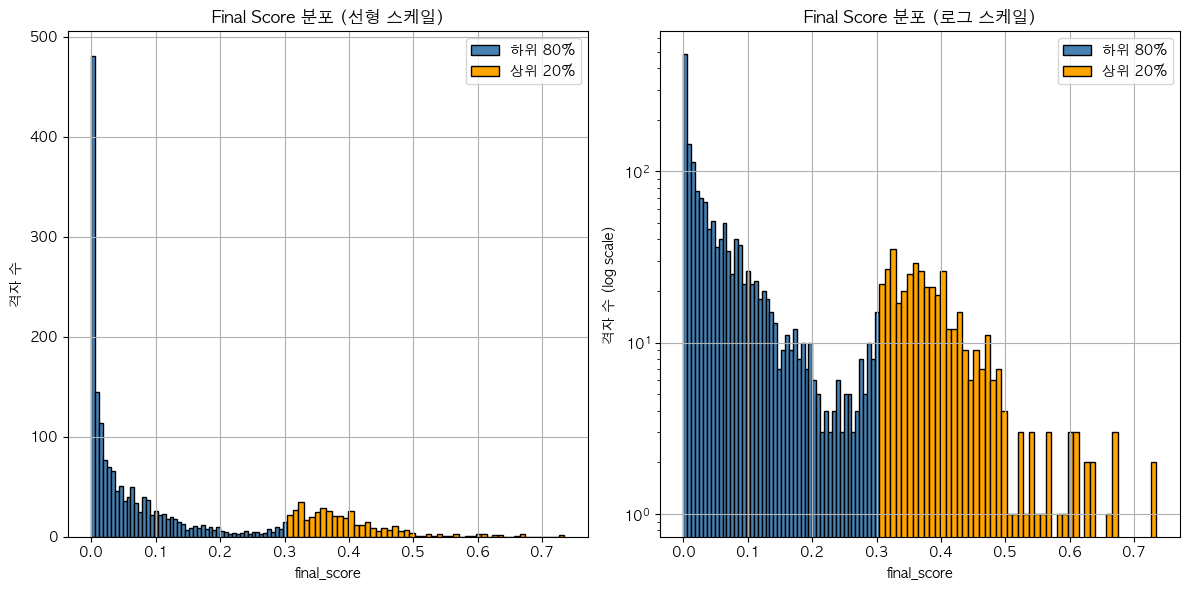

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 한글 폰트 설정 (Mac용)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
df = pd.read_csv("../data/processed/future_demand_gridded_2.csv")

# 상위 20% 기준값
threshold = df['final_score'].quantile(0.80)

# 시각화
plt.figure(figsize=(12, 6))

# 1. 선형 스케일 히스토그램
plt.subplot(1, 2, 1)
plt.hist(
    df[df['final_score'] <= threshold]['final_score'], bins=50,
    color='steelblue', edgecolor='black', label='하위 80%'
)
plt.hist(
    df[df['final_score'] > threshold]['final_score'], bins=50,
    color='orange', edgecolor='black', label='상위 20%'
)
plt.title("Final Score 분포 (선형 스케일)")
plt.xlabel("final_score")
plt.ylabel("격자 수")
plt.legend()
plt.grid(True)

# 2. 로그 스케일 히스토그램
plt.subplot(1, 2, 2)
plt.hist(
    df[df['final_score'] <= threshold]['final_score'], bins=50,
    color='steelblue', edgecolor='black', label='하위 80%'
)
plt.hist(
    df[df['final_score'] > threshold]['final_score'], bins=50,
    color='orange', edgecolor='black', label='상위 20%'
)
plt.yscale('log')
plt.title("Final Score 분포 (로그 스케일)")
plt.xlabel("final_score")
plt.ylabel("격자 수 (log scale)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# XX 참고용 XX

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
future_df = pd.read_csv("../data/processed/future_demand_gridded_2.csv")
current_df = pd.read_csv("../data/processed/grid_features.csv")

# 병합
merged = pd.merge(
    current_df[['grid_id', 'demand_score']],
    future_df[['grid_id', 'adjusted_ev_demand']],
    on='grid_id',
    how='inner'
)

# 요약 통계 출력
print("현재 수요 (demand_score):")
print(merged['demand_score'].describe())
print("\n미래 수요 (adjusted_ev_demand):")
print(merged['adjusted_ev_demand'].describe())


현재 수요 (demand_score):
count    6081.000000
mean      177.113550
std       450.488835
min         0.000000
25%         0.000000
50%         0.000000
75%        67.000000
max      4967.000000
Name: demand_score, dtype: float64

미래 수요 (adjusted_ev_demand):
count    6081.000000
mean       59.638563
std       267.325584
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      7121.700000
Name: adjusted_ev_demand, dtype: float64
